In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms

### Installing additional packages for visualization
To visualize data and the outputs of your model, you need to install `seaborn` and `sklearn`. You can do so via `pip install seaborn scikit-learn`. Note however that these packages are not available in the environment used for testing your code. This means you should not use either of these packages outside of this notebook (which is not run on Artemis and also not graded.)

In [2]:
import visualization
import seaborn as sns

# Project 2: Variational Autoencoder (10 pts)
The goal if this project is to impelement the Variational Autoencoder (VAE). The main idea is to augment an autoencoder architecture with probabilistic latent embeddings. The autoencoder consists of two parts: An encoder that takes inputs and encodes them into a lower-dimensional manifold. The decoder than maps these embeddings back to the original inputs. Thus, the latent embeddings of the encoder are ought to be compressed representations. In the VAE, the encoder instead outputs a latent (variational) distribution from which the latent embeddings are sampled. This "smoothens" the latent space of the autoencoder and allows for example sampling new latent representations (i.e. generating new data) or interpolating between two latent embeddings (while the decoder still provides meaningful reconstructions). 

## Your task
Complete the missing code. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

## General Remarks

Only functionality in the python files will be graded. Carefully read the method docstrings to understand the task, parameters and what output is expected.
Fill in the missing code at the markers in the files `vae/vae.py`, `vae/encoder.py`, `vae/decoder.py`
```python
###########################
# YOUR CODE HERE
###########################
```
Do not add or modify any code at other places in the notebook and python code files except where otherwise explicitly stated.
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Using the `torch.distributions` package
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

## Select an accelerator (CPU or GPU)

Select an accelerator for this project: If you have a GPU available, it will greatly speed up computations. It should however also be feasible to run this notebook entirely on a CPU.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'  # uncomment this line to run the model on the CPU
print(f'Using device {device}')

Using device cuda


## Load the MNIST dataset

In [4]:

batch_size = 128
dataset = datasets.MNIST 
if device == 'cuda':
    train_loader = torch.utils.data.DataLoader(
        dataset('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        dataset('data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=1000, shuffle=True, num_workers=1, pin_memory=True
    )
elif device == 'cpu':
    train_loader = torch.utils.data.DataLoader(
        dataset('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset('data', train=False, download=True, transform=transforms.ToTensor()),
        batch_size=1000, shuffle=True,
    )


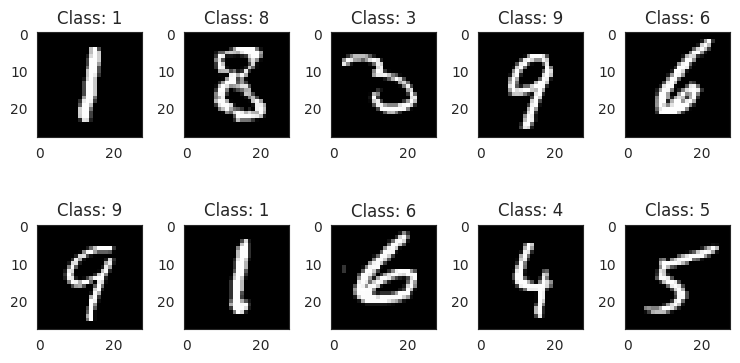

In [5]:
# Visualize a few random samples from the dataset

visualization.visualize_mnist(train_loader)

## Task 1: Encoder (1 pt)
The encoder network produces the parameters of the variational distribution (Slide 102). 
In our case, the variational distribution $q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)})$ is multivariate normal with diagonal covariance, so we encoder needs to produce its mean and the (diagonal of the) covariance matrix.
The encoder has the following architecture
<img src="img/encoder.png" alt="Encoder" style="width: 200px;"/>
The encoder produces the parameters $\boldsymbol{\mu}^{(i)} \in \mathbb{R}^L$ and $\log \boldsymbol{\sigma}^{(i)} \in \mathbb{R}^L$ for each sample $i$ in the mini batch. 
Note that $\log \boldsymbol{\sigma}^{(i)}$ can be negative, we convert it into a diagonal positive-definite covariance matrix as $\boldsymbol{\Sigma}^{(i)} = \operatorname{diag}(\exp(\log \boldsymbol{\sigma}^{(i)}))^2)$

You need to implemenet this functionality in `vae/encoder.py`:
- `forward` **(1 pt)**: Maps a batch of inputs to parameters of the corresponding variational distributions

## Task 2: Reparametrization sampling (1.5 pts)
Given the parameters $\boldsymbol{\mu}^{(i)}$ and $\log \boldsymbol{\sigma}^{(i)}$ of the variational distribution, we need to generate samples $\mathbf{z}^{(i)} \sim q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)}) = \mathcal{N}(\mathbf{z}^{(i)} | \boldsymbol{\mu}^{(i)}, \boldsymbol{\Sigma}^{(i)})$ to estimate the ELBO. 
We draw one sample $\mathbf{z}^{(i)}$ for each instance $i$ in the mini-batch (Slide 104).
It's important to draw samples using reparametrization here, so that it's possible to obtain gradient w.r.t. the parameters of the encoder.

Functions `torch.normal` or `torch.Tensor.normal_` might be useful here.

You need to implemenet this functionality in `vae/vae.py`:
- `sample_with_reparametrization` **(1.5 pts)**: Takes parameters of the variational distribution and draws samples from them using the reparametrization trick such that we get gradients for the parameters of the encoder

## Task 3: Decoder (1 pt)
The decoder takes the samples $\mathbf{z}^{(i)}$ and produces the parameters $\boldsymbol{\theta}^{(i)} \in \mathbb{R}^D$ of the data likelihood $p_{\boldsymbol{\theta}^{(i)}}(\mathbf{x}^{(i)}|\mathbf{z}^{(i)})$.
We use the following simple architecture for the decoder

<img src="img/decoder.png" alt="Decoder" style="width: 150px;"/>

Our data $\mathbf{x}^{(i)} \in \{0, 1\}^D$ is binary, so we use Bernoulli likelihood (Slide 95)
$$p_{\boldsymbol{\theta}^{(i)}}(\mathbf{x}^{(i)}|\mathbf{z}^{(i)}) = \prod_{j=1}^D \left(\theta_{j}^{(i)}\right)^{x_{j}^{(i)}} \left(1 - \theta_{j}^{(i)}\right)^{1 - x_{j}^{(i)}}$$
Recall that the **negative log-likelihood** of the Bernoulli model is also called binary cross entropy.

The parameters $\theta_{j}^{(i)}$ must be in $(0, 1)$, which we enforce using the sigmoid function.

You need to implemenet this functionality in `vae/decoder.py`:
- `forward` **(1 pt)**: Reconstruct inputs from their corresponding latent codes. The reconstructions (i.e. outputs of the decoder) should be in $(0, 1)$.

## Task 4: KL divergence (2 pts)
To compute the ELBO, we will need to compute the KL divergence. 
$$\mathbb{KL}(q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)}) || p(\mathbf{z}^{(i)}))$$
Where $p(\mathbf{z}^{(i)})$ is the standard L-dimensional normal distribution (zero mean, identity covariance).
This can be done in closed form (Slide 99).

You need to implemenet this functionality in `vae/vae.py`:
- `kl_divergence` **(2 pts)**: Computes the KL divergence between the normal distribution parametrized by the variational parameters $\boldsymbol{\mu}^{(i)}$ and $\log \boldsymbol{\sigma}^{(i)}$ and standard normal distribution $\mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$

## Task 5: ELBO (3 pts)
Finally, we can compute the ELBO using all the methods that we implemented above.
ELBO for a single sample $\mathbf{x}^{(i)} \in \{0, 1\}^D$ is computed as
$$\mathcal{L}_i(\boldsymbol{\psi}, \boldsymbol{\lambda}) = \mathbb{E}_{\mathbf{z}^{(i)} \sim q_{\boldsymbol{\phi}^{(i)}} (\mathbf{z}^{(i)})}\left[\log p_{\boldsymbol{\theta}^{(i)}}(\mathbf{x}^{(i)} | \mathbf{z}^{(i)})\right] - \mathbb{KL}(q_{\boldsymbol{\phi}^{(i)}}(\mathbf{z}^{(i)}) || p(\mathbf{z}))$$

In practice it's more efficient to compute the ELBO for a minibatch $\mathcal{B}$ of samples 
$$\mathcal{L}(\boldsymbol{\psi}, \boldsymbol{\lambda}) = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x}^{(i)} \in \mathcal{B}} \mathcal{L}_i(\boldsymbol{\psi}, \boldsymbol{\lambda})$$
where the variational parameters $\boldsymbol{\phi}^{(i)}$ are produced by the **encoder network** $g_{\boldsymbol{\lambda}}$ (i.e. $\boldsymbol{\phi}^{(i)} = g_{\boldsymbol{\lambda}}(\mathbf{x}^{(i)})$),
and the likelihood parameters $\boldsymbol{\theta}^{(i)}$ are produced by the **decoder network** $f_{\boldsymbol{\psi}}$ (i.e. $\boldsymbol{\theta}^{(i)} = f_{\boldsymbol{\psi}}(\mathbf{x}^{(i)})$).

Overview of this procedure is provided on Slide 103.

You need to implemenet this functionality in `vae/vae.py`:
- `elbo` **(3 pts)**: Computes the ELBO for a minibatch of samples as stated above. We approximate expectations by only using one sample (per input).

## Task 6: Generating new data (1.5 pts)
We can generate new samples using the procedure described on Slide 108.
Function `torch.bernoulli` might be useful here.

You need to implemenet this functionality in `vae/vae.py`:
- `sample` **(1.5 pts)**: Generates samples from the VAE by sampling in the latent space and then does "reconstructing" using the decoder network.

### Training the VAE

Now we train the defined VAE model on the MNIST dataset. This should not take more than a few minutes if you are training on a CPU and be significantly faster if you are using a GPU.

In [6]:
from vae import VAE

In [7]:
obs_dim = 784  # MNIST images are of shape [1, 28, 28]
latent_dim = 32  # Size of the latent variable z
hidden_dim = 400  # Size of the hidden layer in the encoder / decoder

vae = VAE(obs_dim, latent_dim, hidden_dim).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [10]:
max_epochs = 5
display_step = 100
for epoch in range(max_epochs):
    print(f'Epoch {epoch}')
    for ix, batch in enumerate(train_loader):
        x, y = batch
        x = x.view(x.shape[0], obs_dim).to(device)  # we flatten the image into 1D array
        opt.zero_grad()
        # We want to maximize the ELBO, so we minimize the negative ELBO
        loss = -vae.elbo(x).mean(-1)
        loss.backward()
        opt.step()
        
        if ix % display_step == 0:
            print(f'  loss = {loss.item():.2f}')

Epoch 0


  loss = 108.32
  loss = 111.70
  loss = 104.38
  loss = 111.04
  loss = 107.92
Epoch 1
  loss = 105.91
  loss = 108.43
  loss = 110.24
  loss = 107.20
  loss = 106.32
Epoch 2
  loss = 107.12
  loss = 105.64
  loss = 106.65
  loss = 107.27
  loss = 105.17
Epoch 3
  loss = 106.79
  loss = 108.99
  loss = 107.86
  loss = 103.50
  loss = 112.81
Epoch 4
  loss = 103.12
  loss = 110.10
  loss = 108.81
  loss = 108.24
  loss = 109.34


### Visualize samples generated by the model

We first qualitatively inspect the instances that our model creates when we randomly sample new latent embeddings and "reconstruct" using the decoder. 

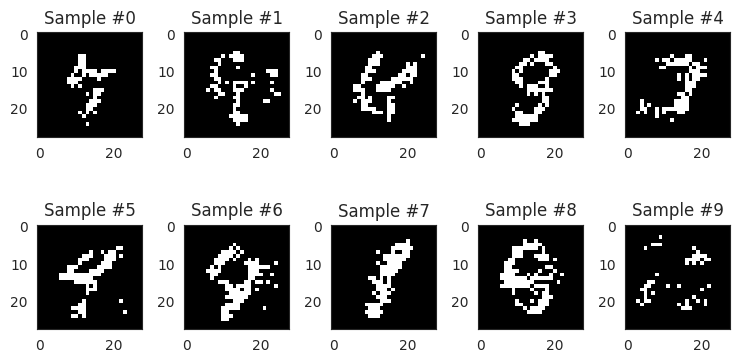

In [11]:
x = vae.sample(10, device)[-1].view(-1, 28, 28).detach().cpu().numpy()
visualization.visualize_vae_samples(x)

While the images here look somewhat similar to the training data and it's possible to discern the shapes of different digits, the sampels are not visually coherent.
You might need to run the above cell several times to obtain images that look decent.

It's possible to obtain images that look a lot better by using more 
powerful encoders & decoders (see `nn.Conv2d` and `nn.ConvTranspose2d`).
However, training such models is slower, unless you have a good GPU.

### Visualize the embeddings produced by the model
Here, we visualize the embeddings learned by the encoder using the following procedure
1. Take a mini-batch `x` (shape `[batch_size, obs_dim]`)
2. Pass `x` through the encoder 
```
mu, logsigma = vae.encoder(x)
```
3. Visualize the mean `mu` for each sample using t-SNE.

<Figure size 1000x700 with 0 Axes>

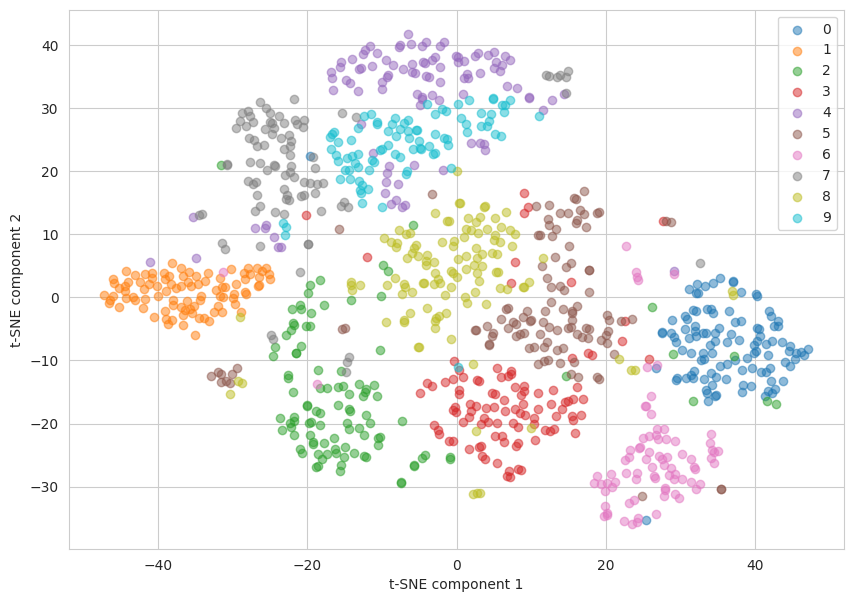

In [12]:
x, y = next(iter(test_loader))
x = x.view(x.shape[0], obs_dim).to(device)
plt.figure(figsize=[10, 7])
visualization.visualize_embeddings(vae, x, y)

As we can see, the encoder learned to assign similar means to the images that belong to the same class. That means, if two samples $x_i$ and $x_j$ belong to the same class, the means $\mu_i$ and $\mu_j$ of their variational distributions $q_i(z_i)$ and $q_j(z_j)$ are nearby, so $z_i$ and $z_j$ will likely be close as well.